In [1]:
# ==================================
# Setup Library
# ==================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer, label_binarize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, auc)
from itertools import cycle

In [2]:
# ==================================
# Evaluation Function
# ==================================
def evaluate_classification(y_true, y_pred, y_probs, multiclass=False):
    average = 'macro' if multiclass else 'binary'
    results = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average=average),
        'Recall': recall_score(y_true, y_pred, average=average),
        'F1-Score': f1_score(y_true, y_pred, average=average)
    }
    try:
        if multiclass:
            results['AUC'] = roc_auc_score(y_true, y_probs, multi_class='ovr', average='macro')
        else:
            results['AUC'] = roc_auc_score(y_true, y_probs)
    except:
        results['AUC'] = np.nan
    return results

In [3]:
# ROC plot
def plot_roc_curve(y_true, y_probs, model_name, multiclass=False):
    plt.figure(figsize=(8, 6))
    if multiclass:
        classes = np.unique(y_true)
        y_true_bin = label_binarize(y_true, classes=classes)
        n_classes = y_true_bin.shape[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
    else:
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_true, y_probs):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [4]:
# Bar plot for metrics
def plot_metrics_comparison(result_df, title_suffix=""):
    result_df.plot(kind='bar', figsize=(10, 6))
    plt.title(f'Metrics Comparison {title_suffix}')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

In [8]:
# ==================================
# Dataset Processing Function
# ==================================
def process_dataset(url, target_name, boosting_model, bagging_model, multiclass=False):
    df = pd.read_csv(url)
    df = df.select_dtypes(include=[np.number]).dropna()

    if target_name == 'num':
        df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

    if target_name == -1:
        target_column = df.columns[-1]
    else:
        target_column = target_name

    X = df.drop(columns=target_column)
    y = df[target_column]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Bagging
    bagging_model.fit(X_train, y_train)
    y_pred_bag = bagging_model.predict(X_test)
    y_prob_bag = bagging_model.predict_proba(X_test)
    eval_bag = evaluate_classification(y_test, y_pred_bag, y_prob_bag if multiclass else y_prob_bag[:,1], multiclass)

    # Boosting
    boosting_model.fit(X_train, y_train)
    y_pred_boost = boosting_model.predict(X_test)
    y_prob_boost = boosting_model.predict_proba(X_test)
    eval_boost = evaluate_classification(y_test, y_pred_boost, y_prob_boost if multiclass else y_prob_boost[:,1], multiclass)

    # Combine result
    result_df = pd.DataFrame([eval_bag, eval_boost], index=['Bagging', 'Boosting'])
    print(result_df)

    # Visualizations
    plot_metrics_comparison(result_df, title_suffix=f'for {target_column}')
    plot_roc_curve(y_test, y_prob_bag if multiclass else y_prob_bag[:,1], 'Random Forest', multiclass)
    plot_roc_curve(y_test, y_prob_boost if multiclass else y_prob_boost[:,1], 'Boosting Model', multiclass)

=== Heart Disease Dataset ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:34:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


          Accuracy  Precision  Recall  F1-Score       AUC
Bagging   0.883333       0.84   0.875  0.857143  0.947338
Boosting  0.833333       0.75   0.875  0.807692  0.894676


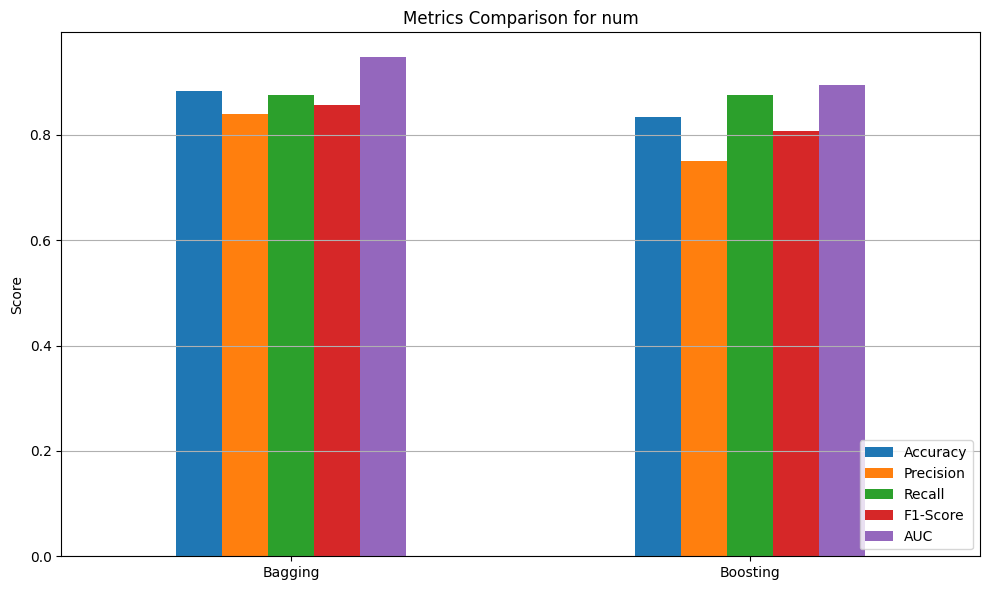

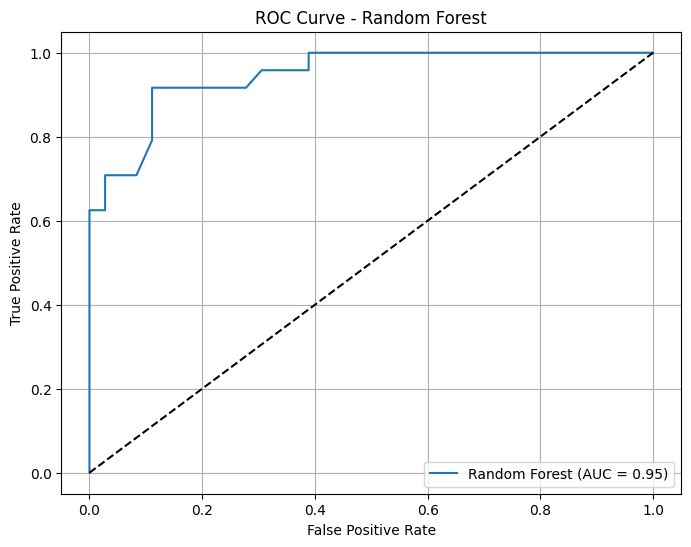

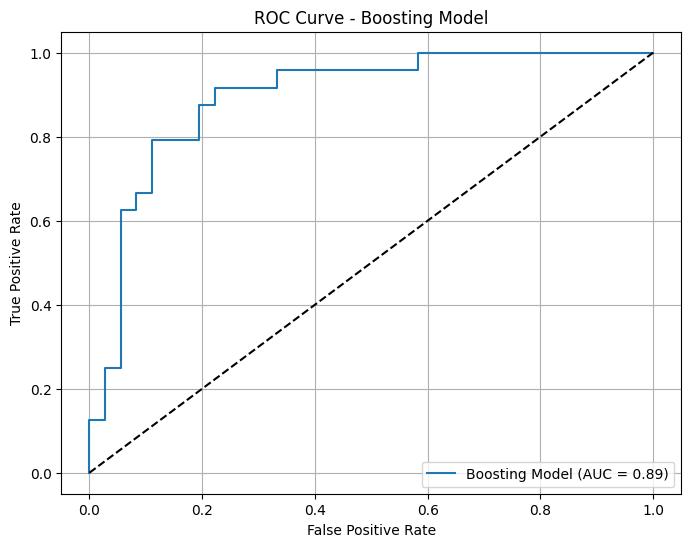

In [9]:
# ==================================
# Heart Disease Dataset (Binary Classification)
# ==================================
print("=== Heart Disease Dataset ===")
url_heart = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/01.%20Machine%20Learning/01.%20Week%201/Dataset/HeartDisease.csv'
process_dataset(url_heart, 'num', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                RandomForestClassifier(random_state=42), multiclass=False)


=== Citarum Water Dataset ===
          Accuracy  Precision    Recall  F1-Score       AUC
Bagging      0.998   0.999153  0.998724  0.998936  0.999979
Boosting     0.998   0.999153  0.998724  0.998936  0.999992


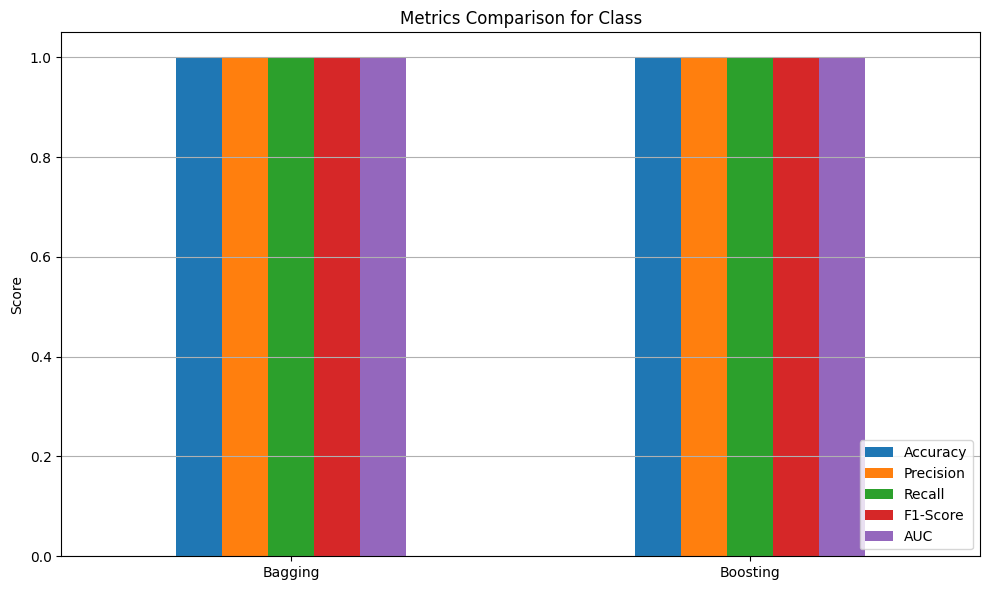

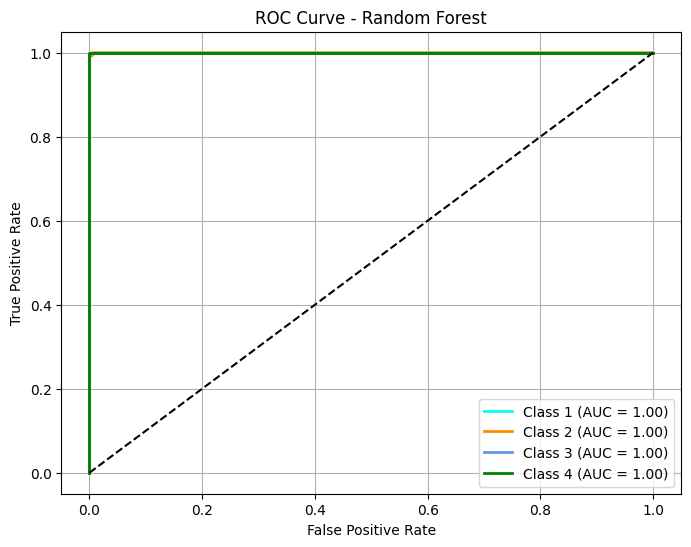

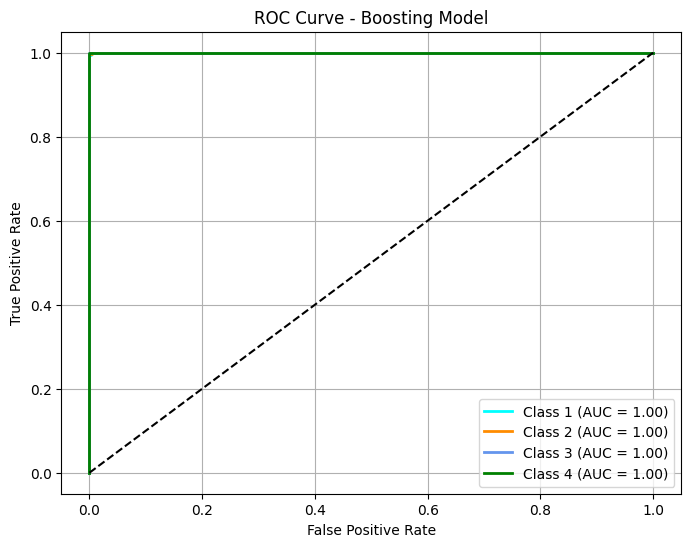

In [10]:
# ==================================
# Citarum Water Dataset (Multiclass Classification)
# ==================================
print("\n=== Citarum Water Dataset ===")
url_citarum = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/01.%20Machine%20Learning/02.%20Week%202/Dataset/CitarumWater.csv"
process_dataset(url_citarum, target_name=-1, # last column
                boosting_model=GradientBoostingClassifier(random_state=42),
                bagging_model=RandomForestClassifier(random_state=42),
                multiclass=True)


=== Income Dataset ===


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


          Accuracy  Precision    Recall  F1-Score  AUC
Bagging   0.309551   0.016433  0.015838  0.015917  NaN
Boosting  0.001945   0.005299  0.012696  0.000672  NaN


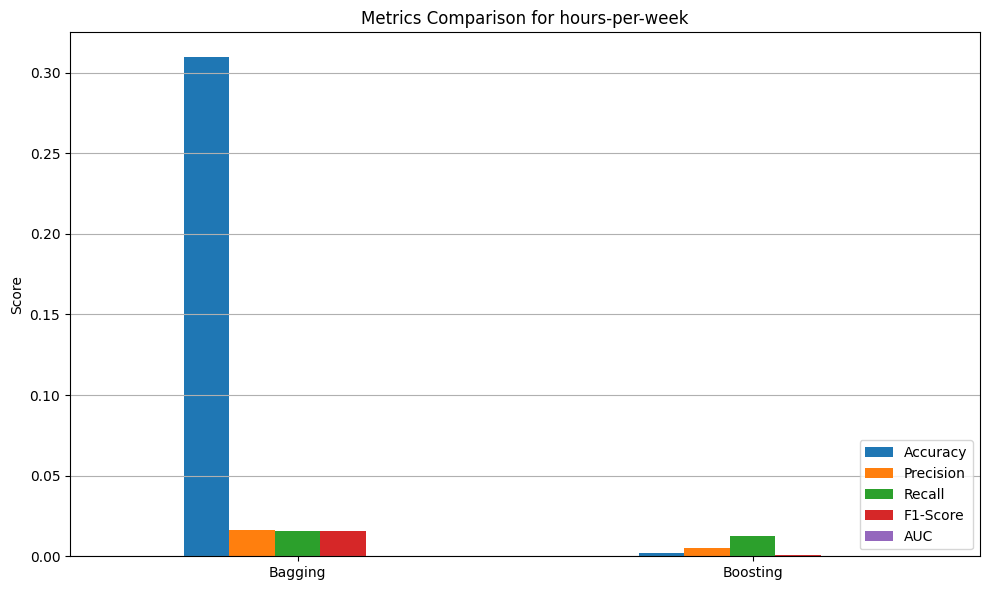

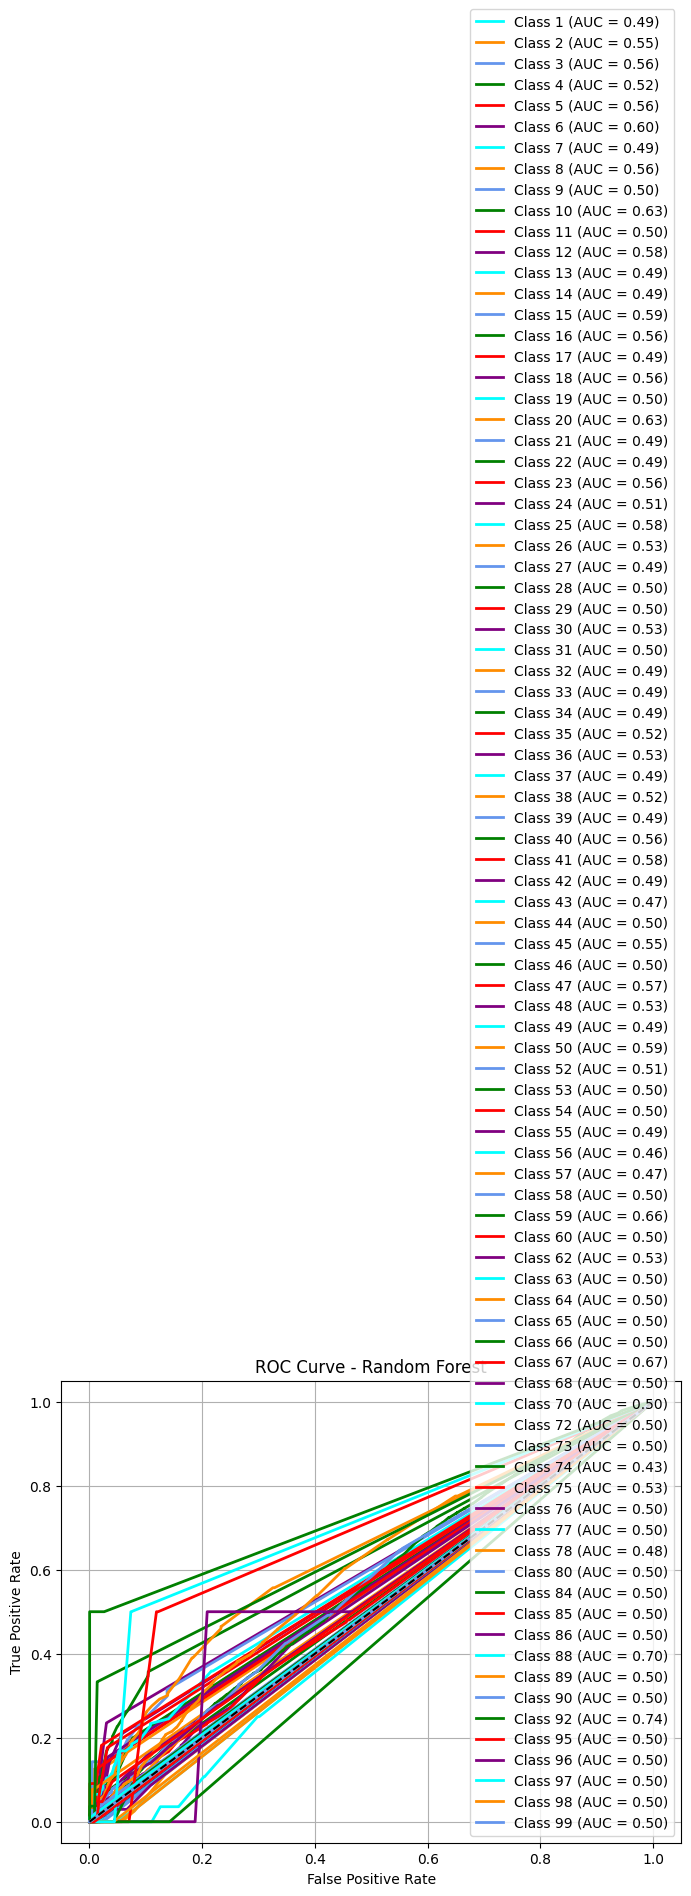

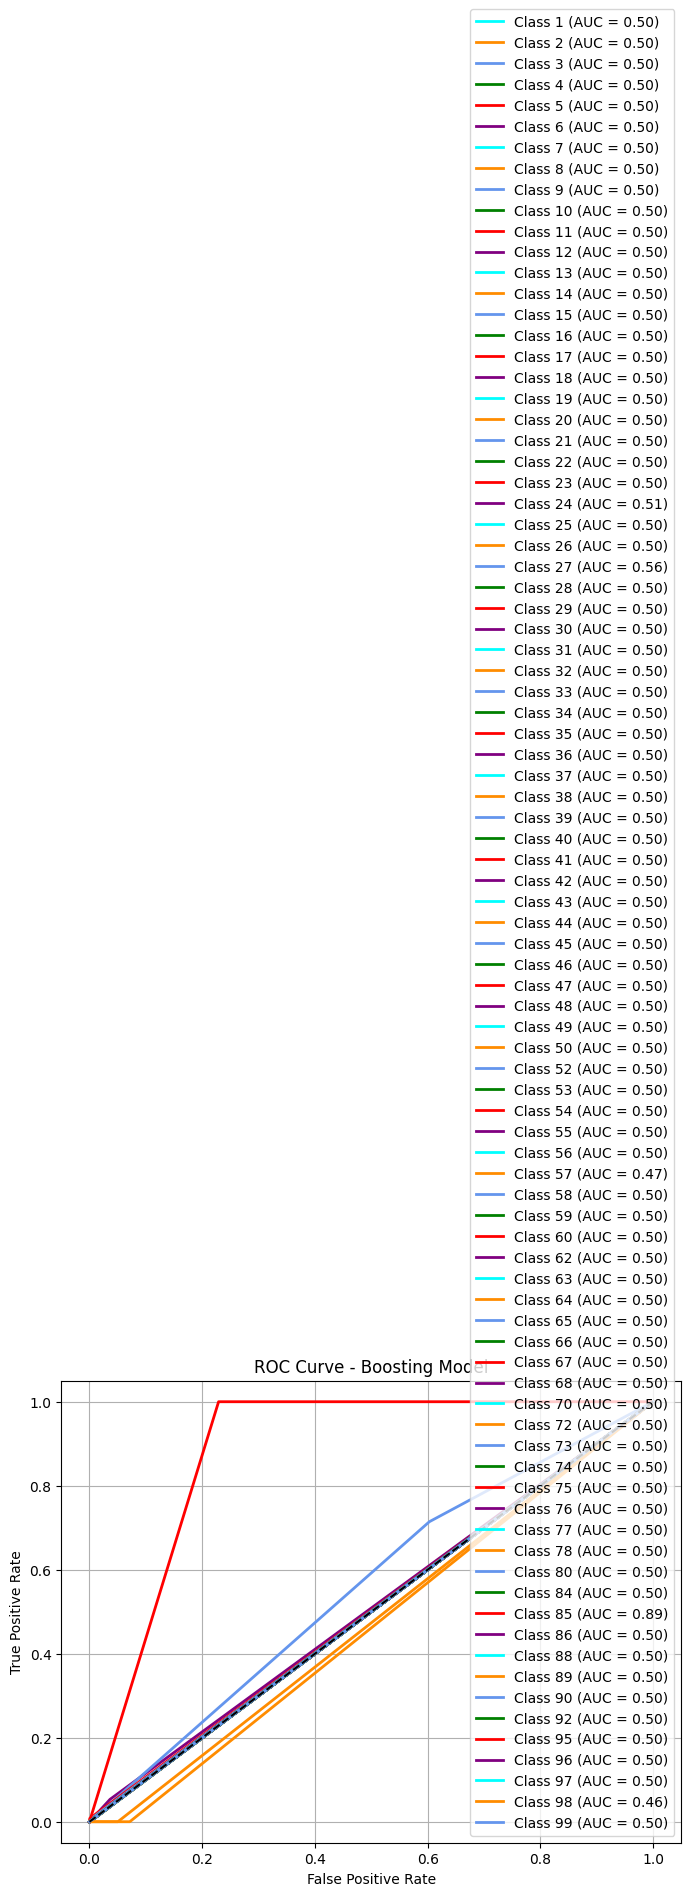

In [11]:
# ==================================
# Income Dataset (Multiclass Classification)
# ==================================
print("\n=== Income Dataset ===")
url_income = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/Dataset/income.csv"
process_dataset(url_income, target_name=-1, # last column
                boosting_model=GradientBoostingClassifier(random_state=42),
                bagging_model=RandomForestClassifier(random_state=42),
                multiclass=True)

#  Penjelasan Matematis Metrik Evaluasi

## 1. **Akurasi (Accuracy)**

**Definisi:**  
Proporsi jumlah prediksi yang benar dibandingkan total semua prediksi.

**Rumus:**
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

**Keterangan:**
- $TP$: True Positive (Prediksi positif benar)
- $TN$: True Negative (Prediksi negatif benar)
- $FP$: False Positive (Prediksi positif salah)
- $FN$: False Negative (Prediksi negatif salah)

> **Akurasi tinggi** berarti banyak prediksi benar, tapi kurang cocok saat data imbang.

---

## 2. **Presisi (Precision)**

**Definisi:**  
Dari semua yang diprediksi positif, berapa banyak yang benar-benar positif.

**Rumus:**
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

> **Presisi tinggi** berarti sedikit kesalahan dalam memprediksi positif.

---

## 3. **Recall (Sensitivitas)**

**Definisi:**  
Dari semua yang sebenarnya positif, berapa banyak yang berhasil diprediksi dengan benar.

**Rumus:**
$$
\text{Recall} = \frac{TP}{TP + FN}
$$

> **Recall tinggi** berarti model tidak melewatkan banyak kasus positif.

---

## 4. **F1-Score**

**Definisi:**  
Harmonic mean dari Presisi dan Recall.  
Cocok digunakan saat kamu butuh keseimbangan antara keduanya.

**Rumus:**
$$
\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

> **F1-Score tinggi** berarti model bagus dalam presisi dan recall sekaligus.

---

## 5. **AUC (Area Under Curve)**

**Definisi:**  
Luas di bawah kurva ROC. Metrik ini mengukur kemampuan model dalam membedakan kelas.

**Interpretasi:**
- $AUC = 1$: Model sempurna
- $AUC = 0.5$: Model tidak lebih baik dari tebak-tebakan acak
- $AUC < 0.5$: Model lebih buruk dari tebak acak

---

## 6. **ROC Curve (Receiver Operating Characteristic Curve)**

**Definisi:**  
Grafik hubungan antara True Positive Rate (TPR) dan False Positive Rate (FPR) pada berbagai threshold.

**Sumbu:**
- X-axis: False Positive Rate
- Y-axis: True Positive Rate

**Formulasi:**
- True Positive Rate (Recall):
$$
\text{TPR} = \frac{TP}{TP + FN}
$$
- False Positive Rate:
$$
\text{FPR} = \frac{FP}{FP + TN}
$$

> **ROC Curve lebih tinggi mendekati kiri atas** berarti performa model lebih baik.

---

#  Kesimpulan: Metrik Evaluasi Mana yang Terbaik?

- **Kalau data seimbang:**  
  → **Akurasi** bisa digunakan.

- **Kalau data tidak seimbang atau ada biaya salah klasifikasi:**  
  → **F1-Score** lebih penting karena memperhitungkan Precision dan Recall bersama-sama.

- **Kalau ingin mengevaluasi kemampuan pemisahan antar kelas:**  
  → **AUC** paling ideal, karena tidak terpengaruh threshold.
